# Anomaly detection with autoencoders

This week we will build an autoencoder for detecting anomalous jets.

Background:
- the goal of anomaly detection here is to find jets which look different from background jets
- for us:
    - background: QCD jets
    - signal: top jets
- of course top jets are not Beyond-the-Standard-Model (BSM), but they are a good test case for BSM anomaly detection
- autoencoders are one of the main anomaly detection tools we have in particle physics
- they consist of an encoder and a decoder
    - encoder: maps input image to a lower dimensional latent vector
    - decoder: maps lower dimensional latent vector to an output image
- the autoencoder is optimised so that the reconstructed output image is as close as possible to the input image
- the loss function is the mean-squared-error (MSE) between the input and output pixels
- the autoencoder has a bottleneck $\Rightarrow$ the latent vector has a much lower dimension than the images
- this means that the autoencoder will focus on reconstructing only the most prominant features in the training data
- therefore, if we train the autoencoder on background (QCD jets), it should poorly reconstruct the signal (top jets)
- we can use the reconstruction score (loss) as an anomaly detection measure
- larger reconstruction loss $\Rightarrow$ more anomalous

An interesting paper:
- QCD or What?
    - https://arxiv.org/abs/1808.08979v1
    - A paper by Tilman and others here in Heidelberg that addresses exactly the problem studied in this tutorial

Outline:
- Imports and plotting set-up
- Building the dataset
    - Preprocessing
    - Dataloaders
- Building an autoencoder (AE)
- Optimising the AE
- Detecting anomalous top jets
    - plot the ROC curve for detecting top jets in test data
    - plot distribution of the reconstruction loss for QCD jets and top jets
- Visualise the input and output QCD and top jets
- Are QCD jets reconstructed better than top jets?
- Bonus question: can we detect anomalous QCD jets?
    - if we train a network on top jets only, can we find QCD jets as anomalies?
    - run the same procedure but with background=tops and signal=QCD :-)

Some tips:
- when constructing the dataset, the training and validation data should consist of only QCD jets, while for testing data there should be equal amounts of QCD and top jets
    - training on QCD jets only is a good approximation to training on a dataset which is mostly background with a tiny amount of signal (which is what you would have in practice)
- when building the autoencoder you can use a fully connected network, or if feeling ambitious, you could use a convolutional neural network
- the bottleneck should be small, say between 5 and 20 dimensions
- this means that the encoder should be a network that accepts an image (e.g. 40x40 pixels flattened to a 1600d vector) and maps it to a vector of dimension 5-20, with some hidden layers
- the decoder should then be a network which takes this 5-20 dimensional vector and maps back to a 1600 dimensional vector
- to visualise and compare input and output jets you just pass a jet through the autoencoder and reshape the output to a 40x40 image and plot it like we did in previous tutorials
- the loss function you should use is the mean squared error loss averaged over the pixels of the jet image
- this is also the anomaly score for each jet
- and remember, most of the code you need is in the previous tutorial notebooks!

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import Sequential, Linear, ReLU

#### Plotting set-up

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(22)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True

## Loading the data

We'll be using the top-tagging data again, so let's just load what we saved out before.

In [3]:
X_train = np.load( "tutorial-3-data/TopTagging/x_train_short.npy")
y_train = np.load( "tutorial-3-data/TopTagging/y_train_short.npy")
X_test = np.load( "tutorial-3-data/TopTagging/x_test_short.npy")
y_test = np.load( "tutorial-3-data/TopTagging/y_test_short.npy")
X_val = np.load( "tutorial-3-data/TopTagging/x_val_short.npy")
y_val = np.load( "tutorial-3-data/TopTagging/y_val_short.npy")

Let's re-jig the data so that we have the training and validation data consisting only of background QCD jets, and the testing data being a mixture of both.  This limits our training data but it's fine for this tutorial.

In [7]:
X_train_qcd = X_train[ y_train == 0.0 ]
X_val_qcd = X_val[ y_val == 0.0 ]

## Building the dataset

For each jet we'll keep the $50$ constituents with the highest $p_T$, with each constituent consisting of $(p_T,\eta,\phi)$.
So each constituent in the jet has three features.

### Preprocessing

We still need to preprocess the jets in much the same way as we did for the CNN study.

In [5]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot

In [6]:
# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)
    
    print( "Calculating eta" )
    etas  = eta(pT,pzs)
    
    print( "Calculating phi" )
    phis  = phi(pxs,pys)
    
    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)
    
    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)
    
    #return z_ori
        
    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) )
    
    return z_out

In [8]:
z_train = constit_to_img( X_train, 50, True, True, True )
z_train_qcd = constit_to_img( X_train_qcd, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )
z_val_qcd = constit_to_img( X_val_qcd, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


In [9]:
print( "Train data shape: " + str(z_train.shape) )
print( "Train data (qcd-only) shape: " + str(z_train_qcd.shape) )
print( "Val data shape: " + str(z_val.shape) )
print( "Val data (qcd-only) shape: " + str(z_val_qcd.shape) )
print( "Test data shape: " + str(z_test.shape) )

Train data shape: (30000, 1600)
Train data (qcd-only) shape: (14960, 1600)
Val data shape: (30000, 1600)
Val data (qcd-only) shape: (14460, 1600)
Test data shape: (30000, 1600)


Now let's cut these so that the training and validation samples are background only.

In [10]:
z_train_p = torch.Tensor( z_train )
z_train_qcd_p = torch.Tensor( z_train_qcd )
z_val_p = torch.Tensor( z_val )
z_val_qcd_p = torch.Tensor( z_val_qcd )
z_test_p = torch.Tensor( z_test )
y_train_p = torch.Tensor( y_train )
y_val_p = torch.Tensor( y_val )
y_test_p = torch.Tensor( y_test )

### Dataloaders

In [14]:
class topcloud_bkg_dataset( Dataset ):
    
    def __init__( self, data ):
        self.data = data
        self.labels = torch.Tensor( [ 0.0 for i in range(len(data)) ] )

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
class topcloud_sig_dataset( Dataset ):
    
    def __init__( self, data, labels ):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [15]:
trn_dataset = topcloud_bkg_dataset( z_train_qcd_p )
val_dataset = topcloud_bkg_dataset( z_val_qcd_p )
tst_dataset = topcloud_sig_dataset( z_test_p, y_test_p.unsqueeze(-1) )

In [16]:
trn_dataloader = DataLoader( trn_dataset, batch_size=64, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=64, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=64, shuffle=True )

## Building an autoencoder

In [78]:
class JetAutoEncoder( torch.nn.Module ):
    
    def __init__( self, data_dim, hiddenlayer_size, bottleneck_size ):
        super( JetAutoEncoder, self ).__init__()
                
        self.enc_layer1 = nn.Linear( data_dim, hiddenlayer_size )
        self.enc_relu_1 = nn.ReLU()
        self.enc_layer2 = nn.Linear( hiddenlayer_size, hiddenlayer_size )
        self.enc_relu_2 = nn.ReLU()
        self.enc_layer3 = nn.Linear( hiddenlayer_size, bottleneck_size )
        
        self.dec_layer1 = nn.Linear( bottleneck_size, hiddenlayer_size )
        self.dec_relu_1 = nn.ReLU()
        self.dec_layer2 = nn.Linear( hiddenlayer_size, hiddenlayer_size )
        self.dec_relu_2 = nn.ReLU()
        self.dec_layer3 = nn.Linear( hiddenlayer_size, data_dim )

        
    def forward( self, batch ):

        x = self.encode( batch )
        x = self.decode( x )

        return x
    
    def encode( self, batch ):
        
        x = self.enc_layer1( batch )
        x = self.enc_relu_1( x )
        x = self.enc_layer2( x )
        x = self.enc_relu_2( x )
        x = self.enc_layer3( x )
        
        return x
    
    def decode( self, batch ):
        
        x = self.dec_layer1( batch )
        x = self.dec_relu_1( x )
        x = self.dec_layer2( x )
        x = self.dec_relu_2( x )
        x = self.dec_layer3( x )

        return x

## Optimising the AutoEncoder

In [79]:
loss_fn = nn.MSELoss()

In [80]:
def train_epoch( dataloader, model, loss_fn, optimizer ):
    
    size = len( dataloader.dataset )
    
    for batch, (X, y) in enumerate(dataloader):

        # pass data through network
        pred = model(X)
        
        # compute loss
        loss = loss_fn( X, pred )

        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print( f"current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]" )

In [81]:
def val_pass( dataloader, model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    vl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X )
            vl += loss_fn( X, pred ).item()

    vl /= num_batches
    print( f"avg val loss per batch: {vl:>8f}" )
    
    return vl

def trn_pass( dataloader, model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    tl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X )
            tl += loss_fn( X, pred ).item()

    tl /= num_batches
    print( f"avg trn loss per batch: {tl:>8f}" )
    
    return tl

In [82]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 100

# re-initialise the model and the optimizer
model = JetAutoEncoder( 1600, 400, 20 )
learning_rate = 0.001
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( trn_dataloader, model, loss_fn, optimizer )
    separator()
    trn_loss = trn_pass( trn_dataloader, model, loss_fn )
    trn_losses.append( trn_loss )
    separator()
    val_loss = val_pass( val_dataloader, model, loss_fn )
    val_losses.append( val_loss )
    separator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
JetAutoEncoder(
  (enc_layer1): Linear(in_features=1600, out_features=400, bias=True)
  (enc_relu_1): ReLU()
  (enc_layer2): Linear(in_features=400, out_features=400, bias=True)
  (enc_relu_2): ReLU()
  (enc_layer3): Linear(in_features=400, out_features=20, bias=True)
  (dec_layer1): Linear(in_features=20, out_features=400, bias=True)
  (dec_relu_1): ReLU()
  (dec_layer2): Linear(in_features=400, out_features=400, bias=True)
  (dec_relu_2): ReLU()
  (dec_layer3): Linear(in_features=400, out_features=1600, bias=True)
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 0.001540  [    0/14960]
current batch loss: 0.000134  [ 6400/14960]
current batch loss: 0.000079  [12800/14960]
-----------------------------------------------
avg trn loss per batch: 0.000071
-------------------------------------------

current batch loss: 0.000022  [ 6400/14960]
current batch loss: 0.000018  [12800/14960]
-----------------------------------------------
avg trn loss per batch: 0.000019
-----------------------------------------------
avg val loss per batch: 0.000020
-----------------------------------------------
|
-----------------------------------------------
Epoch 19
-----------------------------------------------
current batch loss: 0.000018  [    0/14960]
current batch loss: 0.000020  [ 6400/14960]
current batch loss: 0.000012  [12800/14960]
-----------------------------------------------
avg trn loss per batch: 0.000019
-----------------------------------------------
avg val loss per batch: 0.000020
-----------------------------------------------
|
-----------------------------------------------
Epoch 20
-----------------------------------------------
current batch loss: 0.000019  [    0/14960]
current batch loss: 0.000019  [ 6400/14960]
current batch loss: 0.000015  [12800/14960]
--------------

avg trn loss per batch: 0.000015
-----------------------------------------------
avg val loss per batch: 0.000016
-----------------------------------------------
|
-----------------------------------------------
Epoch 37
-----------------------------------------------
current batch loss: 0.000016  [    0/14960]
current batch loss: 0.000015  [ 6400/14960]
current batch loss: 0.000019  [12800/14960]
-----------------------------------------------
avg trn loss per batch: 0.000015
-----------------------------------------------
avg val loss per batch: 0.000016
-----------------------------------------------
|
-----------------------------------------------
Epoch 38
-----------------------------------------------
current batch loss: 0.000016  [    0/14960]
current batch loss: 0.000011  [ 6400/14960]
current batch loss: 0.000018  [12800/14960]
-----------------------------------------------
avg trn loss per batch: 0.000015
-----------------------------------------------
avg val loss per batc

current batch loss: 0.000014  [ 6400/14960]
current batch loss: 0.000009  [12800/14960]
-----------------------------------------------
avg trn loss per batch: 0.000013
-----------------------------------------------
avg val loss per batch: 0.000014
-----------------------------------------------
|
-----------------------------------------------
Epoch 56
-----------------------------------------------
current batch loss: 0.000012  [    0/14960]
current batch loss: 0.000015  [ 6400/14960]
current batch loss: 0.000015  [12800/14960]
-----------------------------------------------
avg trn loss per batch: 0.000013
-----------------------------------------------
avg val loss per batch: 0.000014
-----------------------------------------------
|
-----------------------------------------------
Epoch 57
-----------------------------------------------
current batch loss: 0.000011  [    0/14960]
current batch loss: 0.000010  [ 6400/14960]
current batch loss: 0.000012  [12800/14960]
--------------

avg trn loss per batch: 0.000012
-----------------------------------------------
avg val loss per batch: 0.000013
-----------------------------------------------
|
-----------------------------------------------
Epoch 74
-----------------------------------------------
current batch loss: 0.000011  [    0/14960]
current batch loss: 0.000013  [ 6400/14960]
current batch loss: 0.000011  [12800/14960]
-----------------------------------------------
avg trn loss per batch: 0.000012
-----------------------------------------------
avg val loss per batch: 0.000013
-----------------------------------------------
|
-----------------------------------------------
Epoch 75
-----------------------------------------------
current batch loss: 0.000011  [    0/14960]
current batch loss: 0.000016  [ 6400/14960]
current batch loss: 0.000013  [12800/14960]
-----------------------------------------------
avg trn loss per batch: 0.000012
-----------------------------------------------
avg val loss per batc

current batch loss: 0.000009  [ 6400/14960]
current batch loss: 0.000013  [12800/14960]
-----------------------------------------------
avg trn loss per batch: 0.000010
-----------------------------------------------
avg val loss per batch: 0.000012
-----------------------------------------------
|
-----------------------------------------------
Epoch 93
-----------------------------------------------
current batch loss: 0.000008  [    0/14960]
current batch loss: 0.000011  [ 6400/14960]
current batch loss: 0.000008  [12800/14960]
-----------------------------------------------
avg trn loss per batch: 0.000011
-----------------------------------------------
avg val loss per batch: 0.000012
-----------------------------------------------
|
-----------------------------------------------
Epoch 94
-----------------------------------------------
current batch loss: 0.000014  [    0/14960]
current batch loss: 0.000011  [ 6400/14960]
current batch loss: 0.000013  [12800/14960]
--------------

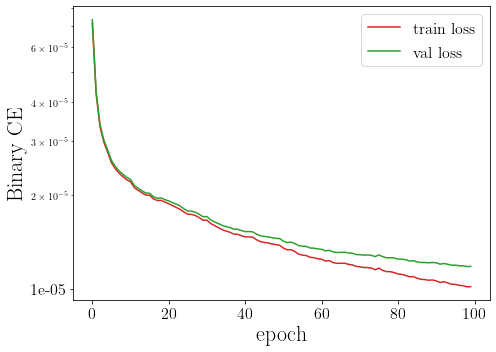

In [83]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( trn_losses, label="train loss", color=c1 )
axs.plot( val_losses, label="val   loss", color=c2 )

axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "Binary CE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

## Detecting anomalous top jets

In [84]:
samp_size = 10000

test_pred = model( z_test_p[:samp_size] ).detach()

test_loss = nn.MSELoss( reduce=False )
test_mse = test_loss( test_pred[:samp_size], z_test_p[:samp_size] )

In [85]:
test_mse.shape

torch.Size([10000, 1600])

In [86]:
test_mse = torch.mean( test_mse, dim=-1)

In [87]:
from sklearn.metrics import roc_curve, roc_auc_score

def closest_point(array, tpr_p=0.3):
    dist = ((array-tpr_p)**2)
    return np.argmin(dist)

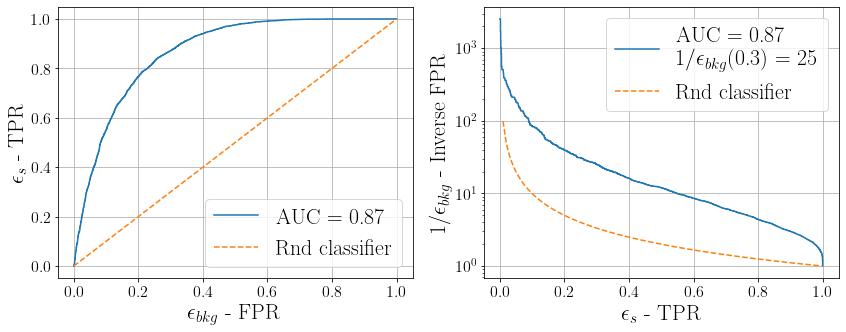

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve(y_test[0:samp_size], test_mse)
auc_score = roc_auc_score(y_test[0:samp_size], test_mse)
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR', fontproperties=axislabelfont)
ax[0].set_ylabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)

ax[1].set_xlabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR', fontproperties=axislabelfont)
for i in range(len(ax)):
    ax[i].legend(prop=axislabelfont)
    ax[i].tick_params(labelsize=axisfontsize)
    ax[i].grid('on')

## Visualise the input and output jets

In [138]:
n_jets = 4
in_qcd_jets = z_test_p[ y_test==0.0 ][ 0:4 ] 
in_top_jets = z_test_p[ y_test==1.0 ][ 0:4 ]
out_qcd_jets = model( in_qcd_jets ).detach().numpy()
out_top_jets = model( in_top_jets ).detach().numpy()
in_qcd_jets = in_qcd_jets.detach().numpy()
in_top_jets = in_top_jets.detach().numpy()

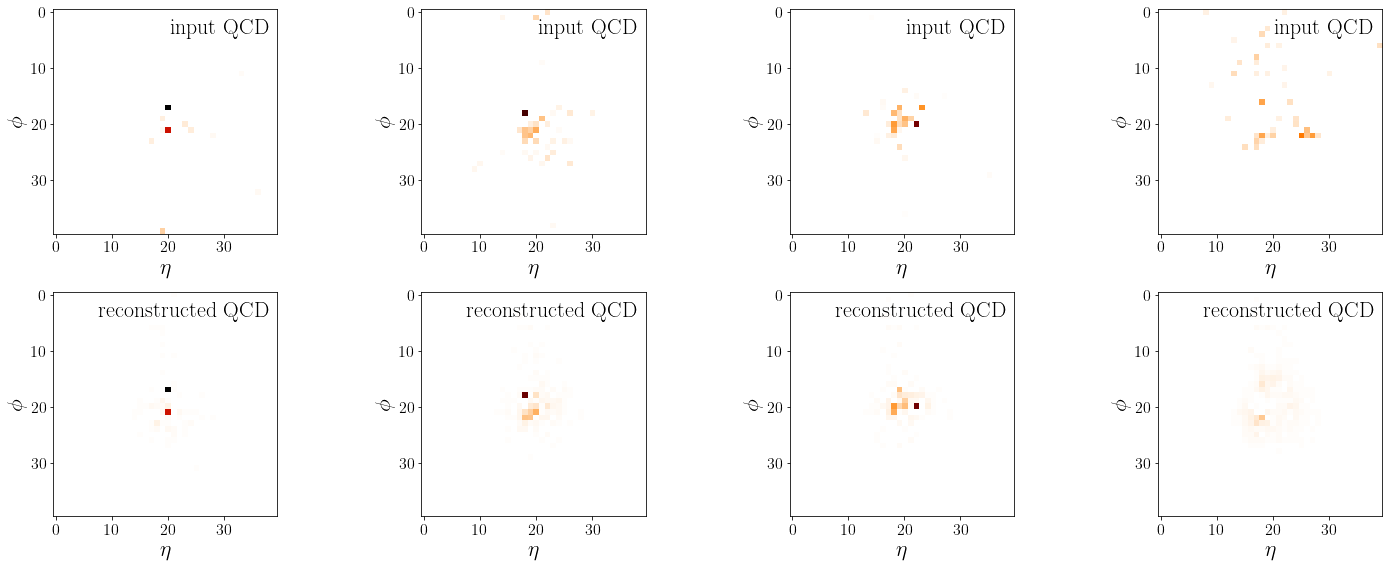

In [172]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( in_qcd_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[1][i].imshow( out_qcd_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[0][i].set_xlabel( '$\eta$', fontproperties=axislabelfont )
    axs[0][i].set_ylabel( '$\phi$', fontproperties=axislabelfont )
    axs[1][i].set_xlabel( '$\eta$', fontproperties=axislabelfont )
    axs[1][i].set_ylabel( '$\phi$', fontproperties=axislabelfont )
    axs[0][i].text( 38, 4, "input QCD", fontproperties=axislabelfont, ha='right' )
    axs[0][i].tick_params( labelsize=axisfontsize )
    axs[1][i].text( 38, 4, "reconstructed QCD", fontproperties=axislabelfont, ha='right' )
    axs[1][i].tick_params( labelsize=axisfontsize )

fig.tight_layout()
fig.show()

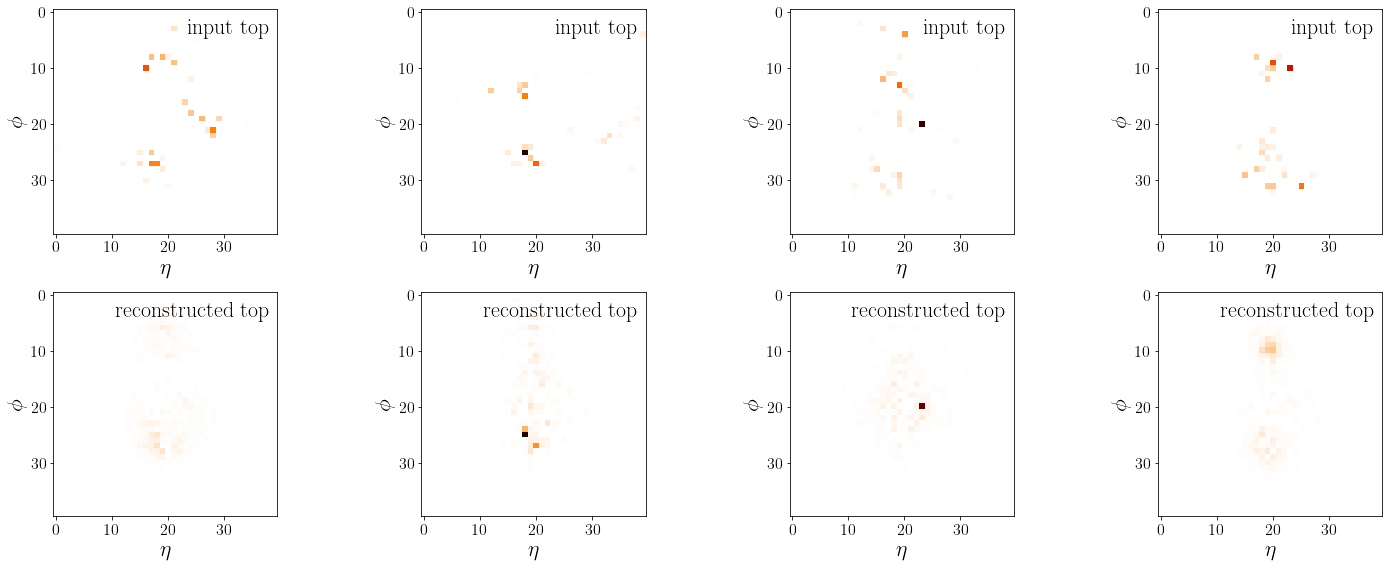

In [171]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( in_top_jets[i].reshape(40,40), cmap='gist_heat_r', vmin=0.0, vmax=0.4 )
    axs[1][i].imshow( out_top_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[0][i].set_xlabel( '$\eta$', fontproperties=axislabelfont )
    axs[0][i].set_ylabel( '$\phi$', fontproperties=axislabelfont )
    axs[1][i].set_xlabel( '$\eta$', fontproperties=axislabelfont )
    axs[1][i].set_ylabel( '$\phi$', fontproperties=axislabelfont )
    axs[0][i].text( 38, 4, "input top", fontproperties=axislabelfont, ha='right' )
    axs[0][i].tick_params( labelsize=axisfontsize )
    axs[1][i].text( 38, 4, "reconstructed top", fontproperties=axislabelfont, ha='right' )
    axs[1][i].tick_params( labelsize=axisfontsize )


fig.tight_layout()
fig.show()

## Are QCD jets better reconstructed than top jets?

Yes.

We can even plot the MSE-per-pixel.

In [135]:
n_jets = 4
in_qcd_jets = z_test_p[ y_test==0.0 ][ 0:4 ] 
in_top_jets = z_test_p[ y_test==1.0 ][ 0:4 ]
out_qcd_jets = model( in_qcd_jets )
out_top_jets = model( in_top_jets )
mse_qcd_jets = test_loss( in_qcd_jets, out_qcd_jets ).detach().numpy()
mse_top_jets = test_loss( in_top_jets, out_top_jets ).detach().numpy()
in_qcd_jets = in_qcd_jets.detach().numpy()
in_top_jets = in_top_jets.detach().numpy()

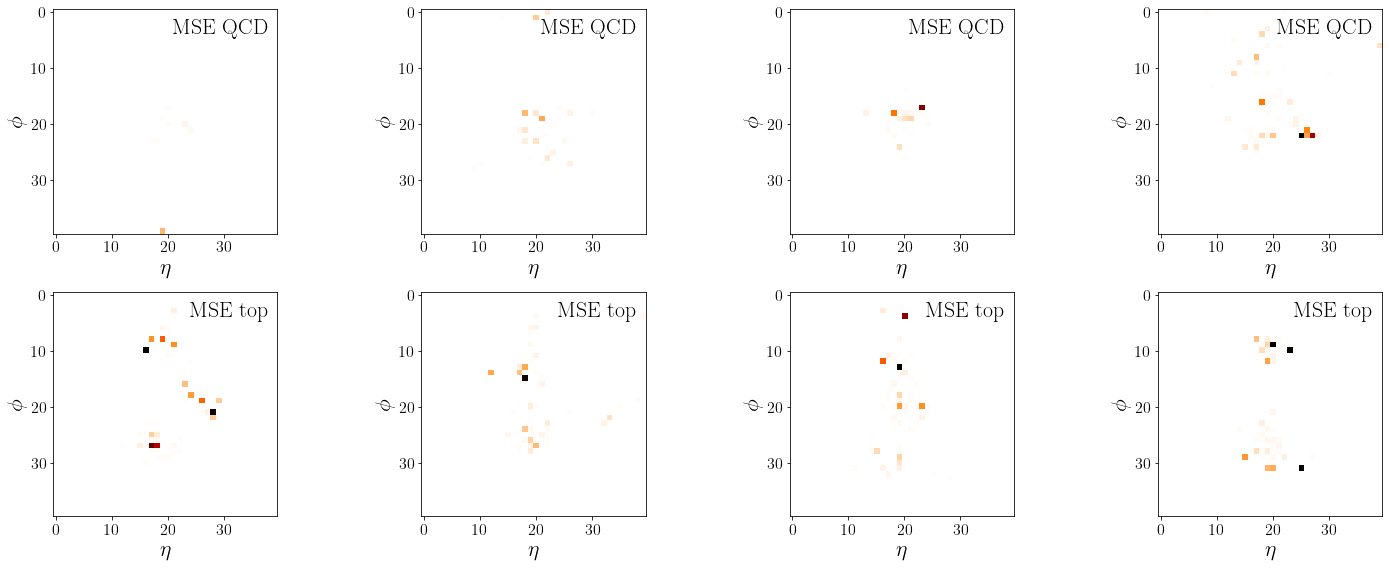

In [170]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( mse_qcd_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.01 )
    axs[1][i].imshow( mse_top_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.01 )
    axs[0][i].set_xlabel( '$\eta$', fontproperties=axislabelfont )
    axs[0][i].set_ylabel( '$\phi$', fontproperties=axislabelfont )
    axs[1][i].set_xlabel( '$\eta$', fontproperties=axislabelfont )
    axs[1][i].set_ylabel( '$\phi$', fontproperties=axislabelfont )
    axs[0][i].text( 38, 4, "MSE QCD", fontproperties=axislabelfont, ha='right' )
    axs[0][i].tick_params( labelsize=axisfontsize )
    axs[1][i].text( 38, 4, "MSE top", fontproperties=axislabelfont, ha='right' )
    axs[1][i].tick_params( labelsize=axisfontsize )

fig.tight_layout()
fig.show()

## Bonus question: can we detect anomalous QCD jets?

Re-do everything for QCD jets as the signal and top jets as the background.

In [154]:
X_train_top = X_train[ y_train == 1.0 ]
X_val_top = X_val[ y_val == 1.0 ]

z_train_top = constit_to_img( X_train_top, 50, True, True, True )
z_val_top = constit_to_img( X_val_top, 50, True, True, True )

print( "Train data (top-only) shape: " + str(z_train_top.shape) )
print( "Val data (top-only) shape: " + str(z_train_top.shape) )

z_train_top_p = torch.Tensor( z_train_top )
z_val_top_p = torch.Tensor( z_val_top )

trn_dataset_2 = topcloud_bkg_dataset( z_train_top_p )
val_dataset_2 = topcloud_bkg_dataset( z_val_top_p )
tst_dataset_2 = topcloud_sig_dataset( z_test_p, y_test_p.unsqueeze(-1) )

trn_dataloader_2 = DataLoader( trn_dataset_2, batch_size=64, shuffle=True )
val_dataloader_2 = DataLoader( val_dataset_2, batch_size=64, shuffle=True )
tst_dataloader_2 = DataLoader( tst_dataset_2, batch_size=64, shuffle=True )

# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 100

# re-initialise the model and the optimizer
model_2 = JetAutoEncoder( 1600, 400, 20 )
learning_rate = 0.001
optimizer = torch.optim.Adam( model_2.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model_2 )

# track train and val losses
trn_losses_2 = []
val_losses_2 = []

for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( trn_dataloader_2, model_2, loss_fn, optimizer )
    separator()
    trn_loss_2 = trn_pass( trn_dataloader_2, model_2, loss_fn )
    trn_losses_2.append( trn_loss_2 )
    separator()
    val_loss_2 = val_pass( val_dataloader_2, model_2, loss_fn )
    val_losses_2.append( val_loss_2 )
    separator()
    print( "|" )
    
print("Done!")

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Train data (top-only) shape: (15040, 1600)
Val data (top-only) shape: (15040, 1600)
-----------------------------------------------
model architecture 
-----------------------------------------------
JetAutoEncoder(
  (enc_layer1): Linear(in_features=1600, out_features=400, bias=True)
  (enc_relu_1): ReLU()
  (enc_layer2): Linear(in_features=400, out_features=400, bias=True)
  (enc_relu_2): ReLU()
  (enc_layer3): Linear(in_features=400, out_features=20, bias=True)
  (dec_layer1): Linear(in_features=20, out_features=400, bias=True)
  (dec_relu_1): ReLU()
  (dec_layer2): Linear(in_features=400, out_features=400

avg val loss per batch: 0.000036
-----------------------------------------------
|
-----------------------------------------------
Epoch 17
-----------------------------------------------
current batch loss: 0.000038  [    0/15040]
current batch loss: 0.000030  [ 6400/15040]
current batch loss: 0.000034  [12800/15040]
-----------------------------------------------
avg trn loss per batch: 0.000035
-----------------------------------------------
avg val loss per batch: 0.000036
-----------------------------------------------
|
-----------------------------------------------
Epoch 18
-----------------------------------------------
current batch loss: 0.000032  [    0/15040]
current batch loss: 0.000041  [ 6400/15040]
current batch loss: 0.000038  [12800/15040]
-----------------------------------------------
avg trn loss per batch: 0.000035
-----------------------------------------------
avg val loss per batch: 0.000035
-----------------------------------------------
|
-------------------

current batch loss: 0.000031  [ 6400/15040]
current batch loss: 0.000033  [12800/15040]
-----------------------------------------------
avg trn loss per batch: 0.000030
-----------------------------------------------
avg val loss per batch: 0.000031
-----------------------------------------------
|
-----------------------------------------------
Epoch 36
-----------------------------------------------
current batch loss: 0.000032  [    0/15040]
current batch loss: 0.000027  [ 6400/15040]
current batch loss: 0.000028  [12800/15040]
-----------------------------------------------
avg trn loss per batch: 0.000029
-----------------------------------------------
avg val loss per batch: 0.000031
-----------------------------------------------
|
-----------------------------------------------
Epoch 37
-----------------------------------------------
current batch loss: 0.000033  [    0/15040]
current batch loss: 0.000028  [ 6400/15040]
current batch loss: 0.000028  [12800/15040]
--------------

avg trn loss per batch: 0.000026
-----------------------------------------------
avg val loss per batch: 0.000028
-----------------------------------------------
|
-----------------------------------------------
Epoch 54
-----------------------------------------------
current batch loss: 0.000024  [    0/15040]
current batch loss: 0.000027  [ 6400/15040]
current batch loss: 0.000029  [12800/15040]
-----------------------------------------------
avg trn loss per batch: 0.000026
-----------------------------------------------
avg val loss per batch: 0.000028
-----------------------------------------------
|
-----------------------------------------------
Epoch 55
-----------------------------------------------
current batch loss: 0.000024  [    0/15040]
current batch loss: 0.000026  [ 6400/15040]
current batch loss: 0.000029  [12800/15040]
-----------------------------------------------
avg trn loss per batch: 0.000026
-----------------------------------------------
avg val loss per batc

current batch loss: 0.000025  [ 6400/15040]
current batch loss: 0.000025  [12800/15040]
-----------------------------------------------
avg trn loss per batch: 0.000024
-----------------------------------------------
avg val loss per batch: 0.000027
-----------------------------------------------
|
-----------------------------------------------
Epoch 73
-----------------------------------------------
current batch loss: 0.000028  [    0/15040]
current batch loss: 0.000024  [ 6400/15040]
current batch loss: 0.000024  [12800/15040]
-----------------------------------------------
avg trn loss per batch: 0.000024
-----------------------------------------------
avg val loss per batch: 0.000027
-----------------------------------------------
|
-----------------------------------------------
Epoch 74
-----------------------------------------------
current batch loss: 0.000026  [    0/15040]
current batch loss: 0.000022  [ 6400/15040]
current batch loss: 0.000024  [12800/15040]
--------------

avg trn loss per batch: 0.000024
-----------------------------------------------
avg val loss per batch: 0.000027
-----------------------------------------------
|
-----------------------------------------------
Epoch 91
-----------------------------------------------
current batch loss: 0.000024  [    0/15040]
current batch loss: 0.000032  [ 6400/15040]
current batch loss: 0.000027  [12800/15040]
-----------------------------------------------
avg trn loss per batch: 0.000024
-----------------------------------------------
avg val loss per batch: 0.000027
-----------------------------------------------
|
-----------------------------------------------
Epoch 92
-----------------------------------------------
current batch loss: 0.000025  [    0/15040]
current batch loss: 0.000026  [ 6400/15040]
current batch loss: 0.000022  [12800/15040]
-----------------------------------------------
avg trn loss per batch: 0.000024
-----------------------------------------------
avg val loss per batc

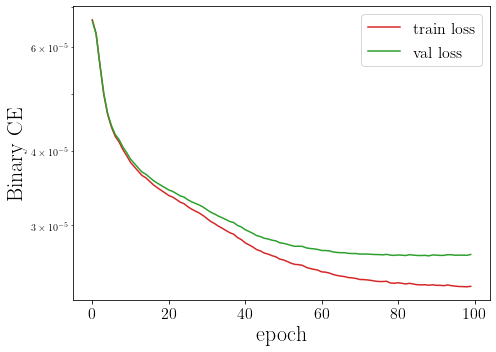

In [155]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( trn_losses_2, label="train loss", color=c1 )
axs.plot( val_losses_2, label="val   loss", color=c2 )

axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "Binary CE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

In [156]:
samp_size = 10000

test_pred_2 = model_2( z_test_p[:samp_size] ).detach()

test_loss_2 = nn.MSELoss( reduce=False )
test_mse_2 = test_loss_2( test_pred_2[:samp_size], z_test_p[:samp_size] )

In [157]:
test_mse_2.shape

torch.Size([10000, 1600])

In [158]:
test_mse_2 = torch.mean( test_mse_2, dim=-1)

We need to flip the labels:

In [160]:
y_test_2 = np.abs( y_test-1.0 )

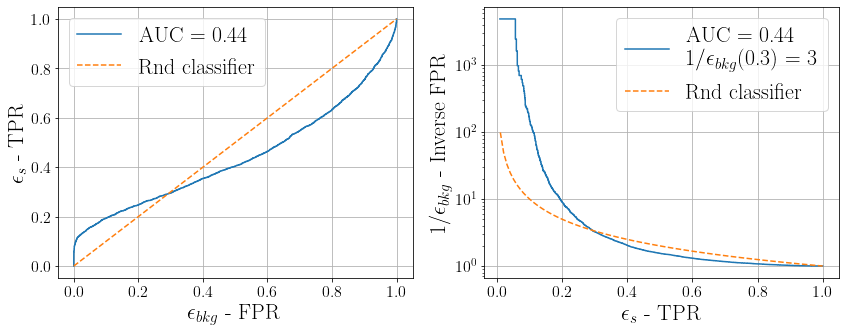

In [161]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve(y_test_2[0:samp_size], test_mse_2)
auc_score = roc_auc_score(y_test_2[0:samp_size], test_mse_2)
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR', fontproperties=axislabelfont)
ax[0].set_ylabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)

ax[1].set_xlabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR', fontproperties=axislabelfont)
for i in range(len(ax)):
    ax[i].legend(prop=axislabelfont)
    ax[i].tick_params(labelsize=axisfontsize)
    ax[i].grid('on')

The AUC is less than 1!!

This means we are doing worse than a random tagger...

Why?

Well we can look at the per-pixel MSE to see what is going on:

In [162]:
n_jets = 4
in_qcd_jets = z_test_p[ y_test==0.0 ][ 0:4 ] 
in_top_jets = z_test_p[ y_test==1.0 ][ 0:4 ]
out_qcd_jets_2 = model_2( in_qcd_jets )
out_top_jets_2 = model_2( in_top_jets )
mse_qcd_jets_2 = test_loss( in_qcd_jets, out_qcd_jets_2 ).detach().numpy()
mse_top_jets_2 = test_loss( in_top_jets, out_top_jets_2 ).detach().numpy()
in_qcd_jets = in_qcd_jets.detach().numpy()
in_top_jets = in_top_jets.detach().numpy()

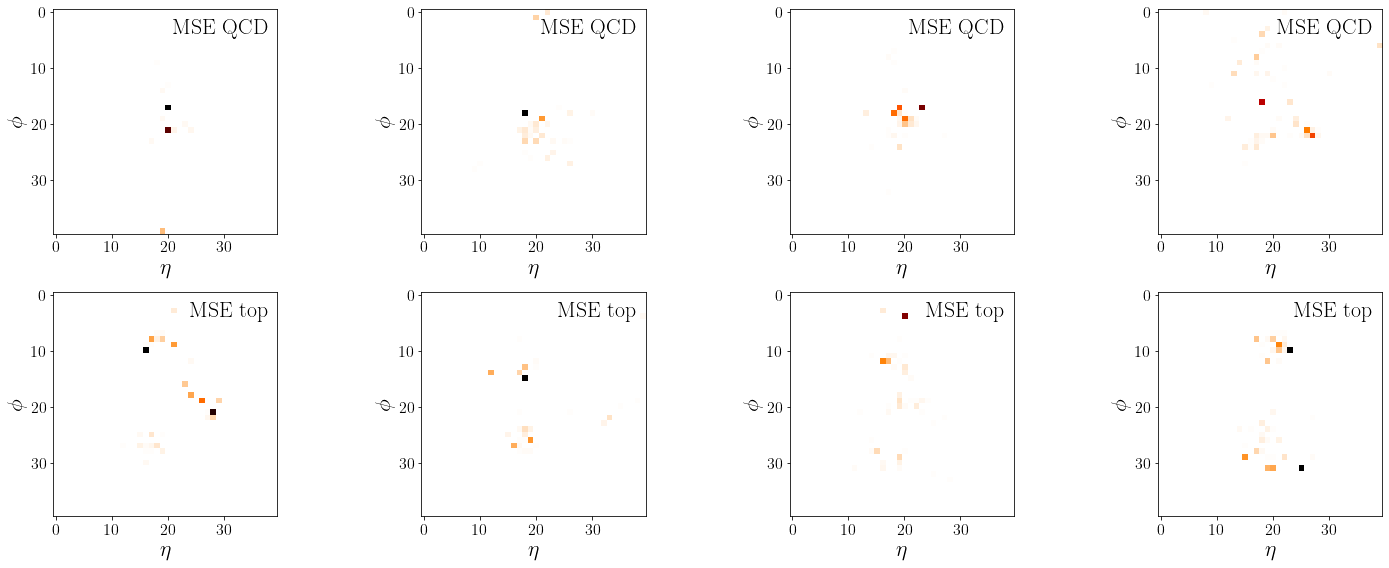

In [169]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( mse_qcd_jets_2[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.01 )
    axs[1][i].imshow( mse_top_jets_2[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.01 )
    axs[0][i].set_xlabel( '$\eta$', fontproperties=axislabelfont )
    axs[0][i].set_ylabel( '$\phi$', fontproperties=axislabelfont )
    axs[1][i].set_xlabel( '$\eta$', fontproperties=axislabelfont )
    axs[1][i].set_ylabel( '$\phi$', fontproperties=axislabelfont )
    axs[0][i].text( 38, 4, "MSE QCD", fontproperties=axislabelfont, ha='right' )
    axs[0][i].tick_params( labelsize=axisfontsize )
    axs[1][i].text( 38, 4, "MSE top", fontproperties=axislabelfont, ha='right' )
    axs[1][i].tick_params( labelsize=axisfontsize )

fig.tight_layout()
fig.show()

Let's look explicitly at the input and reconstructed jets:

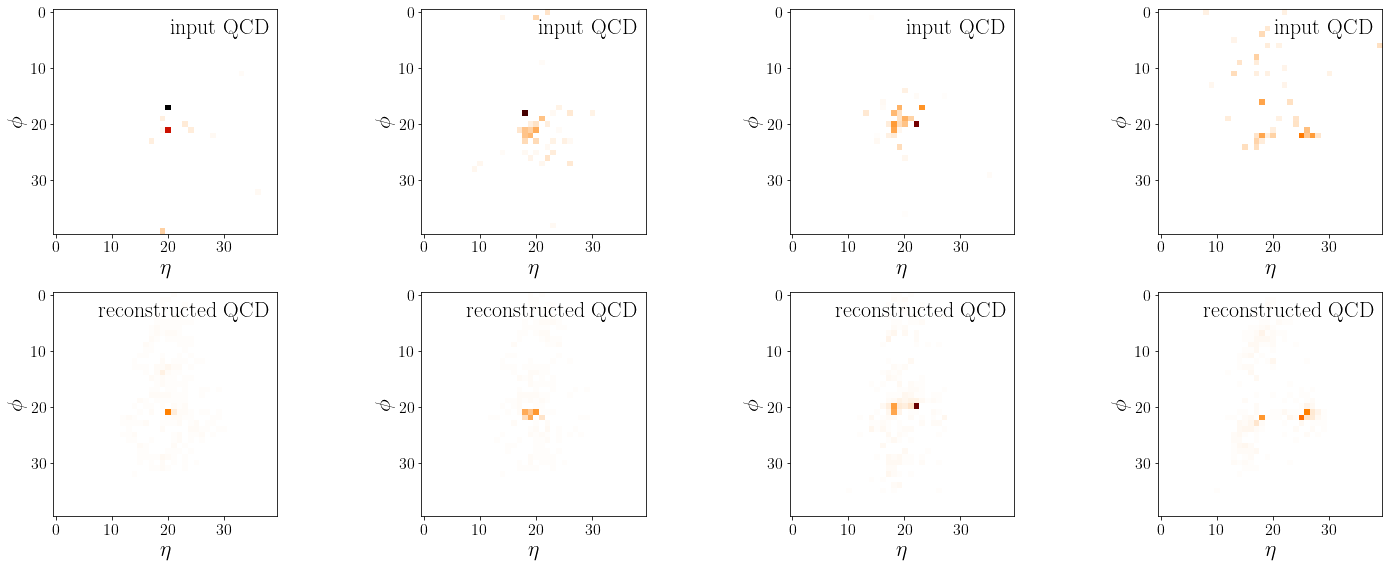

In [167]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( in_qcd_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[1][i].imshow( out_qcd_jets_2.detach().numpy()[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[0][i].set_xlabel( '$\eta$', fontproperties=axislabelfont )
    axs[0][i].set_ylabel( '$\phi$', fontproperties=axislabelfont )
    axs[1][i].set_xlabel( '$\eta$', fontproperties=axislabelfont )
    axs[1][i].set_ylabel( '$\phi$', fontproperties=axislabelfont )
    axs[0][i].text( 38, 4, "input QCD", fontproperties=axislabelfont, ha='right' )
    axs[0][i].tick_params( labelsize=axisfontsize )
    axs[1][i].text( 38, 4, "reconstructed QCD", fontproperties=axislabelfont, ha='right' )
    axs[1][i].tick_params( labelsize=axisfontsize )

fig.tight_layout()
fig.show()

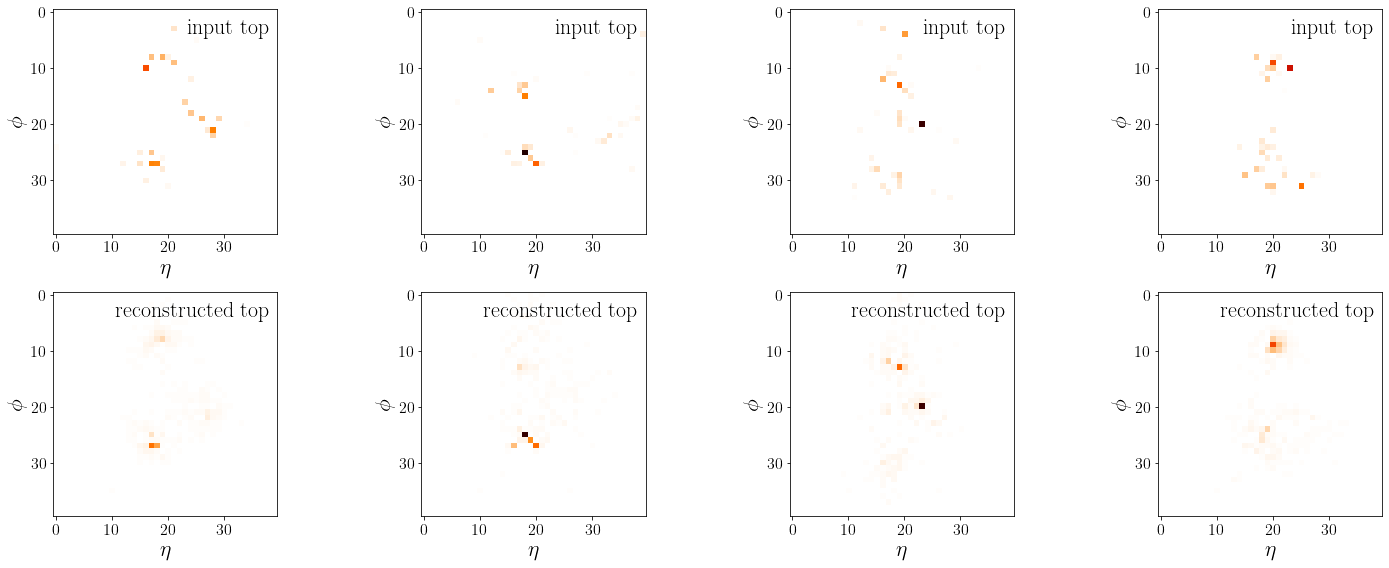

In [168]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( in_top_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[1][i].imshow( out_top_jets_2.detach().numpy()[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[0][i].set_xlabel( '$\eta$', fontproperties=axislabelfont )
    axs[0][i].set_ylabel( '$\phi$', fontproperties=axislabelfont )
    axs[1][i].set_xlabel( '$\eta$', fontproperties=axislabelfont )
    axs[1][i].set_ylabel( '$\phi$', fontproperties=axislabelfont )
    axs[0][i].text( 38, 4, "input top", fontproperties=axislabelfont, ha='right' )
    axs[0][i].tick_params( labelsize=axisfontsize )
    axs[1][i].text( 38, 4, "reconstructed top", fontproperties=axislabelfont, ha='right' )
    axs[1][i].tick_params( labelsize=axisfontsize )

fig.tight_layout()
fig.show()

We can see that despite training the tagger on top jets, the QCD jets are still slightly better reconstructed than the top jets.